# Análises

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import TimeSeriesSplit

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


import matplotlib.cm as cm
import matplotlib.colors as mcolors


c:\Users\User\anaconda3\envs\PhD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def metrics(y_test, y_pred, scores):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, scores)#, max_fpr=0.1)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [3]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [4]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.iloc[:, 0]
    test_scores_std = df.iloc[:, 1]
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [5]:
def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    """
    Encontra o threshold ótimo com base na curva ROC,
    considerando apenas FPR <= max_fpr se especificado.
    Retorna fpr, tpr, thresholds, best_threshold e roc_auc.
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]

    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]

    return fpr, tpr, thresholds, best_threshold, roc_auc


def plot_roc_multiple(models_results, max_fpr=None):
    """
    Plota múltiplas curvas ROC no mesmo gráfico.
    
    models_results: lista de dicionários, cada um contendo:
        {
            'name': str,
            'fpr': array,
            'tpr': array,
            'thresholds': array,
            'best_threshold': float,
            'roc_auc': float
        }
    """
    plt.figure(figsize=(10, 6))

    for result in models_results:
        fpr = result['fpr']
        tpr = result['tpr']
        thresholds = result['thresholds']
        best_threshold = result['best_threshold']
        roc_auc = result['roc_auc']
        name = result['name']

        # Índice do melhor threshold
        optimal_idx = np.where(thresholds == best_threshold)[0][0]

        # Curva do modelo
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")
        # Melhor threshold
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], zorder=5, s=50, label=f"{name} - Best Th = {best_threshold:.3f}")

    # Linha de referência
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1, label='Aleatório')

    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title(f'Curvas ROC{" (FPR ≤ " + str(max_fpr) + ")" if max_fpr else ""}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [6]:
development = pd.read_csv('./data/development_phishing.csv')
validation = pd.read_csv('./data/validation_phishing.csv')

In [7]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(4012, 49)

In [8]:
train_no_anomalies

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,target
0,2,1,2,41,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,0,0
3,3,1,2,89,12,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,1,0
4,1,0,4,101,6,0,0,0,3,0,...,0,0,0,1,-1,1,1,0,1,0
5,3,2,4,118,2,0,0,0,2,0,...,0,0,0,0,-1,1,1,1,1,0
6,1,0,5,56,1,0,0,0,0,0,...,1,0,1,1,0,-1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,3,1,2,94,0,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,1,0
7995,2,0,1,60,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0
7996,3,1,2,116,1,0,0,0,2,1,...,0,0,0,1,-1,1,1,1,1,0
7997,1,0,5,60,1,0,0,0,0,0,...,0,0,0,1,0,1,1,0,1,0


In [9]:
feature_model = [col for col in development.columns if col not in ['target']]

In [10]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [11]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [12]:
with open('./models/pipeline_iForest_cmaes.pkl', 'rb') as file:
    pipe_model_iforest_cmaes = pickle.load(file)
with open('./models/pipeline_ecod_cmaes.pkl', 'rb') as file:
    pipe_model_ecod_cmaes = pickle.load(file)
with open('./models/pipeline_copod_cmaes.pkl', 'rb') as file:
    pipe_model_copod_cmaes = pickle.load(file)
with open('./models/pipeline_elliptic_cmaes.pkl', 'rb') as file:
    pipe_model_elliptic_cmaes = pickle.load(file)

In [13]:
# ------------------------------
# Função para encontrar threshold ótimo
# ------------------------------
def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr = fpr[mask]
        tpr = tpr[mask]
        thresholds = thresholds[mask]
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)
    optimal_idx = np.argmax(tpr - fpr)
    best_threshold = thresholds[optimal_idx]
    return fpr, tpr, thresholds, best_threshold, roc_auc


# ------------------------------
# Função para calcular métricas
# ------------------------------
def compute_metrics(y_true, y_pred, y_score):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    auc = roc_auc_score(y_true, y_score)
    return acc, prec, rec, spec, f1, auc


# ------------------------------
# Dicionário de modelos
# ------------------------------
models = {
    "iForest": {
        "CMA-ES": pipe_model_iforest_cmaes
    },
    "ECOD": {
        "CMA-ES": pipe_model_ecod_cmaes
    },
    "COPOD": {
        "CMA-ES": pipe_model_copod_cmaes
    },
    "EE": {
        "CMA-ES": pipe_model_elliptic_cmaes
    }
}




In [14]:
rows = []

for model_name, variants in models.items():
    for method, pipe in variants.items():
        # scores dos conjuntos de desenvolvimento e validação
        if hasattr(pipe, "predict_proba"):
            scores_dev = pipe.predict_proba(X_dev)[:, 1]
            scores_valid = pipe.predict_proba(X_valid)[:, 1]
        elif hasattr(pipe, "decision_function"):
            if model_name in ["iForest", "EE"]:
                scores_dev = -pipe.decision_function(X_dev)
                scores_valid = -pipe.decision_function(X_valid)
            else:
                scores_dev = pipe.decision_function(X_dev)
                scores_valid = pipe.decision_function(X_valid)
        elif hasattr(pipe, "score_samples"):
            if model_name in ["iForest", "EE"]:
                scores_dev = -pipe.score_samples(X_dev)
                scores_valid = -pipe.score_samples(X_valid)
            else:
                scores_dev = pipe.score_samples(X_dev)
                scores_valid = pipe.score_samples(X_valid)
        else:
            scores_dev = pipe.predict(X_dev)
            scores_valid = pipe.predict(X_valid)

        # encontra threshold ótimo usando desenvolvimento
        _, _, _, best_threshold, auc_dev = find_optimal_threshold(y_dev, scores_dev, max_fpr=1)

        # ------------------------------
        # Avaliação no conjunto de desenvolvimento
        # ------------------------------
        y_pred_dev = (scores_dev >= best_threshold).astype(int)
        acc_dev, prec_dev, rec_dev, spec_dev, f1_dev, auc_dev = compute_metrics(y_dev, y_pred_dev, scores_dev)
        rows.append([
            model_name, method, "dev",
            acc_dev, prec_dev, rec_dev, spec_dev, f1_dev, auc_dev
        ])

        # ------------------------------
        # Avaliação no conjunto de validação
        # ------------------------------
        y_pred_valid = (scores_valid >= best_threshold).astype(int)
        acc_valid, prec_valid, rec_valid, spec_valid, f1_valid, auc_valid = compute_metrics(y_valid, y_pred_valid, scores_valid)
        rows.append([
            model_name, method, "valid",
            acc_valid, prec_valid, rec_valid, spec_valid, f1_valid, auc_valid
        ])

# ------------------------------
# Monta DataFrame e arredonda
# ------------------------------
df_results = pd.DataFrame(rows, columns=[
    "Model", "Method", "Set", "Accuracy", "Precision", "Recall", "Specificity", "F1-score", "AUC-ROC"
])

df_results = df_results.round(3)


In [15]:
df_results[df_results['Set'] == 'valid']

,Model,Method,Set,Accuracy,Precision,Recall,Specificity,F1-score,AUC-ROC
1,iForest,CMA-ES,valid,0.776,0.842,0.687,0.868,0.757,0.778
3,ECOD,CMA-ES,valid,0.577,0.561,0.754,0.396,0.643,0.628
5,COPOD,CMA-ES,valid,0.566,0.646,0.312,0.825,0.421,0.584
7,EE,CMA-ES,valid,0.758,0.794,0.704,0.813,0.746,0.765


In [16]:
df_results[df_results['Set'] == 'dev']

,Model,Method,Set,Accuracy,Precision,Recall,Specificity,F1-score,AUC-ROC
0,iForest,CMA-ES,dev,0.777,0.832,0.692,0.861,0.756,0.784
2,ECOD,CMA-ES,dev,0.533,0.526,0.636,0.431,0.576,0.546
4,COPOD,CMA-ES,dev,0.538,0.587,0.245,0.828,0.346,0.520
6,EE,CMA-ES,dev,0.760,0.797,0.695,0.824,0.743,0.769


In [17]:
# === Funções auxiliares ===
def find_optimal_threshold(y_true, y_scores, max_fpr=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    if max_fpr is not None:
        mask = fpr <= max_fpr
        fpr, tpr, thresholds = fpr[mask], tpr[mask], thresholds[mask]
    roc_auc = roc_auc_score(y_true, y_scores, max_fpr=max_fpr)
    optimal_idx = np.argmax(tpr - fpr)
    return fpr, tpr, thresholds, thresholds[optimal_idx], roc_auc



def plot_roc_multiples(models_results, title, max_fpr=None):
    """
    Plota múltiplas curvas ROC com cores distintas para cada modelo.
    """

    plt.figure(figsize=(10, 6))

    # Colormap elegante – uma cor única para cada curva
    cmap = cm.get_cmap("tab10", len(models_results))

    for i, result in enumerate(models_results):
        fpr, tpr = result['fpr'], result['tpr']
        thresholds, best_th = result['thresholds'], result['best_threshold']
        auc = result['roc_auc']
        name = result['name']

        # Cor exclusiva para este modelo
        color = cmap(i)

        # Índice do ponto ótimo
        optimal_idx = np.where(thresholds == best_th)[0][0]

        # Curva ROC
        plt.plot(
            fpr, tpr,
            lw=2,
            color=color,
            label=f"{name} (AUC = {auc:.3f}, Th = {best_th:.2e})"
        )

        # Ponto ótimo
        plt.scatter(
            fpr[optimal_idx], tpr[optimal_idx],
            color=color, edgecolor="black",
            s=100, zorder=5, marker="o"
        )

        # Linhas tracejadas auxiliares
        plt.axhline(y=tpr[optimal_idx], color=color, linestyle="--", alpha=0.6)
        plt.axvline(x=fpr[optimal_idx], color=color, linestyle="--", alpha=0.6)

    # Linha aleatória (baseline)
    plt.plot([0, 1], [0, 1], linestyle=":", color="gray", lw=1.5)

    plt.xlabel("Taxa de Falsos Positivos", fontsize=14.5)
    plt.ylabel("Taxa de Verdadeiros Positivos", fontsize=14.5)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.title(title, fontsize=15)
    plt.legend(loc="lower right", fontsize=13, frameon=True)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


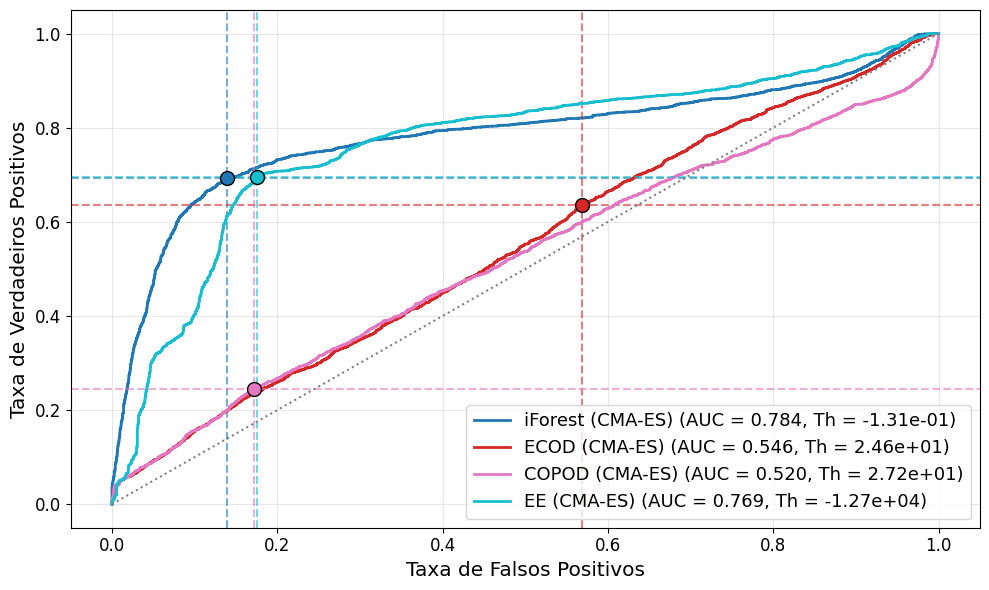

In [ ]:
# Model registry
families = {
    "iForest": {
        "CMA-ES": pipe_model_iforest_cmaes
    },
    "ECOD": {
        "CMA-ES": pipe_model_ecod_cmaes
    },
    "COPOD": {
        "CMA-ES": pipe_model_copod_cmaes
    },
    "EE": {
        "CMA-ES": pipe_model_elliptic_cmaes
    }
}

# Modelos cujo score precisa ser invertido
list_models_pyod = ['iForest', "EE"]

# Lista geral de resultados para TODOS os modelos
all_results = []

for family_name, models in families.items():
    for opt_name, model in models.items():

        # Ajuste de sinal
        if family_name in list_models_pyod:
            y_scores = -model.decision_function(X_dev)
        else:
            y_scores = model.decision_function(X_dev)

        fpr, tpr, thr, best_th, auc = find_optimal_threshold(y_dev, y_scores)

        all_results.append({
            "name": f"{family_name} ({opt_name})",
            "fpr": fpr,
            "tpr": tpr,
            "thresholds": thr,
            "best_threshold": best_th,
            "roc_auc": auc
        })

plot_roc_multiples(all_results, title="")
